In [1]:
magma_dir = '/home/marco/epfl/magma/'
transformers_dir = '/home/marco/epfl/transformers/'

#### AWS

In [2]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [3]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

sys.path.insert(0, transformers_dir+'examples/seq2seq/')
import utils

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
MODEL = 'bart'
MODELS = {}

In [5]:
# Output path
OUTPUT_PATH = bucket_dir+'fine-tuning/gps_bart_para_wordembed/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [6]:
data_dir = bucket_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

### **Init**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
from transformers import EvalPrediction

tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [8]:
def import_model_tok(model_name_or_path, cache, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path, cache_dir=cache)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path, cache_dir=cache)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path, cache_dir=cache)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [9]:
def print_examples(model_name_or_path, cache, df_val,
    min_length, max_length, length_penalty, no_repeat_ngram_size, n_examples=5):
    
    df_examples = df_val.sample(n_examples, axis='index', random_state=config.SEED)
    
    model, tokenizer = import_model_tok(model_name_or_path, cache)
    model = model.to(device)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
            
        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt', truncation=True).to(device),
            min_length = min_length,
            max_length = max_length,
            length_penalty = length_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size,
            early_stopping = True)[0]
        summ_num_tok = len(summ_enc)
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print('Prediction\n%s (%d tok):\n'%(model_name_or_path, summ_num_tok))
        print(fill(summ, 100))
        print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Compute Metrics

In [18]:
def compute_metrics(model_name_or_path, cache, df_val,
    min_length, max_length, length_penalty, no_repeat_ngram_size, batch_size=8):
    
    model, tokenizer = import_model_tok(model_name_or_path, cache)
    model = model.to(device)
    
    summarization_metrics = utils.build_compute_metrics_fn('summarization', tokenizer)

    input_ids = tokenizer(df_val.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)
    
    reference_ids = tokenizer(df_val.bullets.tolist(), return_tensors='pt', padding=True).input_ids
    reference_ids = reference_ids.split(batch_size)
    
    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    metrics_final = {}
    avg_len = len(input_ids)
    
    for batch, label_ids in zip(input_ids, reference_ids):

        pred_ids = model.generate(
            batch.to(device),
            min_length = min_length,
            max_length = max_length,
            length_penalty = length_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size,
            early_stopping = True)
        ep = EvalPrediction(pred_ids.cpu(), label_ids)
        
        metrics = summarization_metrics(ep)
        for k in metrics.keys():
            if k not in metrics_final:
                metrics_final[k] = 0
            metrics_final[k] += (metrics[k] / avg_len)

        pbar.update(1)
    pbar.close()
    return metrics_final

## **Sentence-Transformers**

In [19]:
data_dir_st = data_dir + 'st/base/'

In [20]:
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])

### **Generative Parameter Search**

In [21]:
model_name_or_path =  bucket_dir+'fine-tuning/ft_bart_para_wordembed/checkpoint-196'

In [22]:
gps_metrics = pd.DataFrame(columns=['min_length', 'max_length', 'length_penalty', 'no_repeat_ngram',
                     'r1_precision', 'r1_recall', 'r1_fmeasure',
                     'r2_precision', 'r2_recall', 'r2_fmeasure',
                     'rL_precision', 'rL_recall', 'rL_fmeasure',
                     'ST', 'W2V'])

In [23]:
min_length_swipe = [5, 10, 15]
max_length_swipe = [100, 150, 200]
length_penalty_swipe = [0, 1, 2]
no_repeat_ngram_size_swipe = [2, 3, 4]

In [24]:
idx = 0
max_trials = len(min_length_swipe)*len(max_length_swipe)*len(length_penalty_swipe)*len(no_repeat_ngram_size_swipe)
for min_length in min_length_swipe:
    for max_length in max_length_swipe:
        for length_penalty in length_penalty_swipe:
            for no_repeat_ngram_size in no_repeat_ngram_size_swipe:
                
                print(''.join(['#']*35))
                print(''.join(['#']*35))
                print('###\t\t\t\t###')
                print('### \tMIN LENGTH: %d\t\t###'%min_length)
                print('### \tMAX LENGTH: %d\t\t###'%max_length)
                print('### \tLENGTH PENALTY: %d\t###'%length_penalty)
                print('### \tNO REPEAT NGRAM: %d\t###'%no_repeat_ngram_size)
                print('### \tPROGRESS: %.2f %%\t###'%(100*round(idx/max_trials, 4)))
                print('###\t\t\t\t###')
                print(''.join(['#']*35))
                print(''.join(['#']*35))
                print()
                
                metrics = compute_metrics(model_name_or_path, cache_dir, df_val,
                    min_length, max_length, length_penalty, no_repeat_ngram_size)
                
                gps_metrics.loc[idx] = [min_length, max_length, length_penalty, no_repeat_ngram_size]+\
                    [metrics[k] for k in metrics if 'sum' not in k and 'len' not in k]
                
                idx += 1
                
                print()
                print_examples(model_name_or_path, cache_dir, df_val,
                    min_length, max_length, length_penalty, no_repeat_ngram_size)

###################################
###################################
###				###
### 	MIN LENGTH: 5		###
### 	MAX LENGTH: 100		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 0.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [00:50<00:00,  1.47s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging 

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (41 tok):

The most common causes of low back pain are mechanical in origin. Mechanical disorders of the lumbar
spine are related to injury, overuse or deformity of a spinal structure.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-life care. News of a poor prognosis can be
difficult to process initially. Patients need

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (35 tok):

Patients with glioblastoma need frank but compassionate information on diagnosis, prognosis,
treatment options, recurrence and end-of-life care.

Reference:
Radiotherapy and temozolomide is suitable for fit elderly patients with glioblastoma.

####################################################################################################

(9783318066241, 'ch6')
Fluid type. Both an open-label and a triple-blind RCT have demonstrated that fluid resuscitation
using lactated Ringer's solution (a balanced salt solution) is associated with a decreased
inflammatory response when compared with fluid resuscitation with normal saline (with a high
chloride content). According to in vitro experiments, it seems that this anti-inflammatory effect
depends on lactate. However, both studies included a small number of patients, and the influence of
lactated Ringer's solution on important outcomes such as OF or m

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 5		###
### 	MAX LENGTH: 100		###
### 	LENGTH PENALTY: 2	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 50.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [00:

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (25 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 5		###
### 	MAX LENGTH: 150		###
### 	LENGTH PENALTY: 1	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 100.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [00

100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 5		###
### 	MAX LENGTH: 200		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 150.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [00

100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-life care. News of a poor prognosis can be
difficult to process initially. Patients need time to ask questions an

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 5		###
### 	MAX LENGTH: 200		###
### 	LENGTH PENALTY: 2	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 200.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [00

100%|██████████| 34/34 [00:53<00:00,  1.57s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (25 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 10		###
### 	MAX LENGTH: 100		###
### 	LENGTH PENALTY: 1	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 250.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 10		###
### 	MAX LENGTH: 150		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 300.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-life care. News of a poor prognosis can be
difficult to process initially. Patients need time to ask questions an

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 10		###
### 	MAX LENGTH: 150		###
### 	LENGTH PENALTY: 2	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 350.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (25 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 10		###
### 	MAX LENGTH: 200		###
### 	LENGTH PENALTY: 1	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 400.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 15		###
### 	MAX LENGTH: 100		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 450.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.54s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-life care. News of a poor prognosis can be
difficult to process initially. Patients need time to ask questions an

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 15		###
### 	MAX LENGTH: 100		###
### 	LENGTH PENALTY: 2	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 500.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (25 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 15		###
### 	MAX LENGTH: 150		###
### 	LENGTH PENALTY: 1	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 550.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 15		###
### 	MAX LENGTH: 200		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 600.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:52<00:00,  1.55s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-life care. News of a poor prognosis can be
difficult to process initially. Patients need time to ask questions an

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (48 tok):

Balanced fluids such as lactated Ringer's solution seem to be associated with a decreased need for
blood products and a lower incidence of renal replacement therapy, hyperkalemia and postoperative
infections when compared with normal saline.

Reference:
Lactated Ringer's solution is associated with a decreased inflammatory response in AP when compared
with normal saline.

####################################################################################################

(9781910797662, 'ch07')
Management of advanced and metastatic disease. A core principle in the management of solid tumors is
to consider control of both the primary and metastatic disease. Several clinical scenarios occur in
bladder cancer. Cancers that are clearly confined to the bladder can potentially be cured if the
primary tumor can be removed or ablated, through surgery, radiation therapy or multimodality
approaches, and ther

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (26 tok):

The management of both the primary and metastatic disease is a key component of the treatment of
bladder cancer.

Reference:
Management of both local and distant metastatic disease should be considered.

####################################################################################################

(9781910797723, 'chp3')
What types of tumor are potentially susceptible to immuno-oncology?. Clearly, the potential
sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the tumor
to trigger an immune response (immunogenicity). Cancer is characterized by an accumulation of
genetic mutations, many of which result in the expression of cancer-specific antigens that can bind
to major histocompatibility complex (MHC) class I molecules on the cancer cell surface. These
antigen-MHC complexes can be recognized by cytotoxic CD8+ lymphocytes, that, if activated, could
potent

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (36 tok):

The sensitivity of a given cancer to immuno-oncology therapies will depend on the ability of the
tumor to trigger an immune response (immunogenicity).

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

###################################
###################################
###				###
### 	MIN LENGTH: 15		###
### 	MAX LENGTH: 200		###
### 	LENGTH PENALTY: 2	###
### 	NO REPEAT NGRAM: 2	###
### 	PROGRESS: 650.00 %	###
###				###
###################################
###################################

100%|██████████| 34/34 [0

100%|██████████| 34/34 [00:53<00:00,  1.56s/it]

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
/h

Prediction
/home/ubuntu/s3/fine-tuning/ft_bart_para_wordembed/checkpoint-196 (57 tok):

The most common causes of low back pain are mechanical in origin; these disorders are related to
injury, overuse or deformity of a spinal structure; different parts of the spine tend to be at
greater risk for change or injury during different decades of life.

Reference:
Mechanical disorders - muscle strain, spondylolisthesis, herniated intervertebral disc,
osteoarthritis, spinal stenosis - are the most common causes of low back pain.

####################################################################################################

(9781912776726, 'ch4')
Patients with glioblastoma have specific information needs. While the amount of information that
patients want varies from person to person, and in some cases understanding may be impaired by
cognitive deficits, patients and their carers need frank but compassionate information on diagnosis,
prognosis, treatment options, recurrence and end-of-li

In [25]:
gps_metrics.to_csv(OUTPUT_PATH+'df.csv')

In [26]:
gps_metrics

,min_length,max_length,length_penalty,no_repeat_ngram,r1_precision,r1_recall,r1_fmeasure,r2_precision,r2_recall,r2_fmeasure,rL_precision,rL_recall,rL_fmeasure,ST,W2V
0,5.0,100.0,0.0,2.0,37.473235,30.400588,32.204706,15.064706,12.381176,12.991765,30.190000,24.669118,26.074706,59.699634,46.050247
1,5.0,100.0,0.0,3.0,37.396765,30.538235,32.218824,14.997059,12.259118,12.854706,29.956471,24.605882,25.902647,59.602797,46.887527
2,5.0,100.0,0.0,4.0,37.642647,30.357647,32.266176,15.298824,12.385882,13.114412,30.505882,24.772059,26.273529,59.373317,46.076926
3,5.0,100.0,1.0,2.0,36.702647,31.708529,32.670588,15.015000,13.045294,13.372059,29.419706,25.437353,26.182647,60.140276,47.275959
4,5.0,100.0,1.0,3.0,36.610882,32.846176,33.216765,15.210294,13.652941,13.725294,29.482059,26.610588,26.845588,60.798801,49.253574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,15.0,200.0,1.0,3.0,36.229412,33.280588,33.188235,14.894118,13.682647,13.619706,28.921471,26.790882,26.637941,60.809714,49.379718
77,15.0,200.0,1.0,4.0,35.972941,32.277941,32.546176,14.902941,13.116176,13.378235,29.052353,26.244412,26.403824,59.983483,49.037555
78,15.0,200.0,2.0,2.0,35.358824,33.326765,32.911765,14.527353,13.734706,13.522353,28.121471,26.547647,26.186176,60.565011,49.135136
79,15.0,200.0,2.0,3.0,35.654118,34.179706,33.415882,14.827941,13.832059,13.677353,28.487647,27.316765,26.752059,60.904437,50.964951


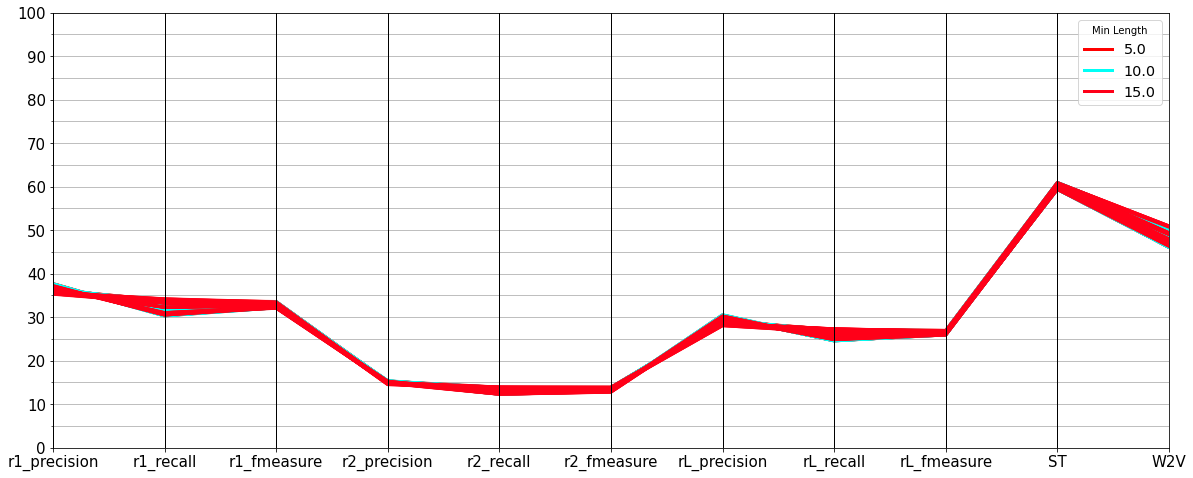

In [27]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
pd.plotting.parallel_coordinates(
    gps_metrics,
    'min_length',
    [c for c in gps_metrics.columns if 'r1' in c or 'r2' in c or 'rL' in c or 'ST' in c or 'W2V' in c],
    ax = ax,
    colormap='hsv',
    linewidth=3,
)
ax.set_yticks(np.linspace(0, 100, 11))
ax.set_yticks(np.linspace(0, 100, 21), minor=True)
for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(15)
for t in ax.yaxis.get_major_ticks():
    t.label.set_fontsize(15)
    
ax.grid(True, which='both')

ax.legend(title='Min Length', fontsize='x-large')

plt.show()